In [ ]:
# In[1]: 必要なモジュール・ライブラリ等インポート
import torch # PyTorch界のコア。皆城乙姫・織姫・輝夜・朔夜
import torch.optim as optim # 最適化アルゴリズム(SGD)
import torch.nn as nn # ニューラルネットワークの定義
import numpy as np # 行列演算
from google.colab import files # Google Colab上でファイルのアップロードとダウンロードの管理
import os # ファイル操作とパス管理
from PIL import Image # 画像の読み込みと操作
from torchvision import transforms # 前処理とデータ拡張
from torch.utils.data import Dataset # カスタムデータセット作成
%matplotlib inline # 画像をセル内表示
from matplotlib import pyplot as plt # ヒートマップ作成
import datetime # 日付と時刻を表示

torch.set_printoptions(edgeitems=3) # テンソル表示は端2つのみ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # デバイスの指定

In [ ]:
# In[2]: 前処理と拡張の定義
def Load_ConvertRGB(image_path):
    images = []
    for file_name in sorted(os.listdir(image_path)):
        if file_name.endswith('.png') or file_name.endswith('.PNG'):
            img = Image.open(os.path.join(image_path, file_name))
            img_rgb = img.convert('RGB')
            images.append(img_rgb)
    return images

def augment_image(image, num_augmented=19):
    transform_augment = transforms.Compose([
        transforms.ColorJitter(
            brightness=(0.8, 1.2),
            contrast=(0.8, 1.2),
            saturation=(0.8, 1.2),
            hue=(-0.1, 0.1)
        )
    ])
    augmented_images = [image]
    for _ in range(num_augmented):
        augmented_images.append(transform_augment(image))
    return augmented_images

def ToTensorWithAugmentation(images, num_augmented=19):
    augmented_tensor_list = []
    transform_to_tensor = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    for img in images:
        augmented_images = augment_image(img, num_augmented=num_augmented)
        augmented_tensor_list.extend([transform_to_tensor(aug_img) for aug_img in augmented_images])
    return augmented_tensor_list

# データセットのパス
train_original = '/content/drive/MyDrive/Colab Notebooks/訓練データ(元・真)'
train_threshold = '/content/drive/MyDrive/Colab Notebooks/訓練データ(2値化・真)'
val_original = '/content/drive/MyDrive/Colab Notebooks/検証データ(元)'
val_threshold = '/content/drive/MyDrive/Colab Notebooks/検証データ(2値化)'

# 訓練データと検証データのロードと変換
train_original_images_augmented = ToTensorWithAugmentation(Load_ConvertRGB(train_original))
train_threshold_images_augmented = ToTensorWithAugmentation(Load_ConvertRGB(train_threshold))
val_original_images_augmented = ToTensorWithAugmentation(Load_ConvertRGB(val_original))
val_threshold_images_augmented = ToTensorWithAugmentation(Load_ConvertRGB(val_threshold))

In [ ]:
# In[3]: データセットの定義
class FafnerDataset(Dataset):
  def __init__(self, original_images, threshold_images, transform=None):
    self.original_images = original_images
    self.threshold_images = threshold_images
    self.transform = transform

  def __len__(self):
    return len(self.original_images)

  def __getitem__(self, idx):
    original_image = self.original_images[idx]
    threshold_image = self.threshold_images[idx]
    threshold_image = (threshold_image > 0.1).float()

    if self.transform:
      original_image = self.transform(original_image)
      threshold_image = self.transform(threshold_image)

    if threshold_image.size(0) == 3:
      threshold_image = (threshold_image.sum(dim=0) > 0).float()

    return original_image, threshold_image

In [ ]:
# In[4]: カスタムデータセットの作成
train_dataset = FafnerDataset(train_original_images_augmented, train_threshold_images_augmented)
val_dataset = FafnerDataset(val_original_images_augmented, val_threshold_images_augmented)

In [ ]:
# In[5]: データローダの作成
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2) # うまくいかんかったらnumを0
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=True, num_workers=2)

# # データローダからバッチを取得し、入力とターゲットのサイズを確認
# for inputs, targets in train_loader:
#     print(f"Batch input size: {inputs.size()}")
#     print(f"Batch target size: {targets.size()}")
#     break  # 最初のバッチのみ確認するためにループを抜ける

Batch input size: torch.Size([32, 3, 256, 256])
Batch target size: torch.Size([32, 256, 256])


In [ ]:
# In[6]: ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.ReLU()

        self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(16, 1, kernel_size=3, padding=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out1 = self.pool1(self.act1(self.bn1(self.conv1(x))))
        out2 = self.pool2(self.act2(self.bn2(self.conv2(out1))))
        out3 = self.act3(self.bn3(self.conv3(out2)))
        out = self.conv4(out3)
        out = self.conv5(out)
        out = self.sigmoid(self.conv6(out))
        return out


In [ ]:
# In[7]: トレーニングループの定義
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(n_epochs + 1):
    loss_train = 0.0

    for imgs, labels in train_loader:
      imgs, labels = imgs.to(device), labels.to(device)

      labels = labels.unsqueeze(1)

      outputs = model(imgs)

      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      loss_train += loss.item()

    if epoch == 1 or epoch % 10 == 0:
      print("{} Epoch:{}, Training Loss:{:.4f}, {}".format(
          datetime.datetime.now(), epoch, loss_train / len(train_loader), outputs.shape
      ))

SyntaxError: invalid syntax (<ipython-input-13-e9d8708fb1c3>, line 15)

In [ ]:
# In[8]: トレーニングループ
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.BCELoss()

training_loop(
    n_epochs =  200,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2025-01-26 00:54:57.467037 Epoch:0, Training Loss:0.6850, torch.Size([12, 1, 256, 256])
2025-01-26 00:56:03.461704 Epoch:1, Training Loss:0.6597, torch.Size([12, 1, 256, 256])
2025-01-26 01:06:15.046076 Epoch:10, Training Loss:0.5237, torch.Size([12, 1, 256, 256])
2025-01-26 01:17:18.029996 Epoch:20, Training Loss:0.3165, torch.Size([12, 1, 256, 256])
2025-01-26 01:28:29.761067 Epoch:30, Training Loss:0.1792, torch.Size([12, 1, 256, 256])
2025-01-26 01:40:10.979751 Epoch:40, Training Loss:0.1519, torch.Size([12, 1, 256, 256])
2025-01-26 01:51:45.153223 Epoch:50, Training Loss:0.1383, torch.Size([12, 1, 256, 256])
2025-01-26 02:03:06.678236 Epoch:60, Training Loss:0.1314, torch.Size([12, 1, 256, 256])
2025-01-26 02:14:12.591337 Epoch:70, Training Loss:0.1247, torch.Size([12, 1, 256, 256])
2025-01-26 02:25:12.253538 Epoch:80, Training Loss:0.1182, torch.Size([12, 1, 256, 256])
2025-01-26 02:36:13.843544 Epoch:90, Training Loss:0.1152, torch.Size([12, 1, 256, 256])
2025-01-26 02:47:13.696

In [ ]:
# In[9]: 検証ループ ～推論～
model.eval()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=2, shuffle=False)

def validate(model, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    total_loss= 0.0

    with torch.no_grad():
      for imgs, labels in loader:

        imgs, labels = imgs.to(device), labels.to(device)

        labels = labels.unsqueeze(1)

        outputs = model(imgs)

        loss = loss_fn(outputs, labels)

        total_loss += loss.item()

        predicted = (outputs > 0.8).float()

        batch_correct_pixels = (predicted == labels).float().mean(dim=(1, 2, 3))

        correct += (batch_correct_pixels >= 0.7).sum().item()

        total += labels.size(0)

    print("Accuracy {}: {:.2f}, Loss: {:.4f}".format(name, correct/total, total_loss/total))

validate(model, train_loader, val_loader)

In [ ]:
# In[9]: 保存
data_path = "./"

torch.save(model.state_dict(), data_path + "FafnerCut.pt")
files.download("FafnerCut.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'ロード\nloaded_model = Net().to(device)\nloaded_model.state_dict(torch.load(data_path + "FafnerCut.pt", map_location=device))\nloaded_model.eval()'

<ipython-input-16-7bb407d3afd0>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/FafnerCut.pt", map_location=torch.device('cpu'))

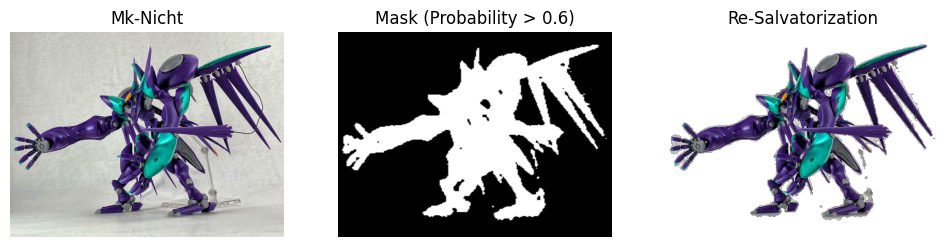

In [ ]:
# In[10]: ヒートマップ
def preprocess_image(image_path):
    original_img = Image.open(image_path).convert('RGB')
    original_size = original_img.size
    img_resized = original_img.resize((255, 255))
    img_tensor = torch.from_numpy(np.array(img_resized).transpose((2, 0, 1))).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0)
    return original_size, img_tensor

def generate_heatmap(image_path, model, shiki):
    model.eval()
    with torch.no_grad():
        original_size, img_tensor = preprocess_image(image_path)
        img_tensor = img_tensor.to(device)
        output = model(img_tensor)

    heatmap = output.squeeze(0).cpu().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    heatmap_img = np.uint8(255 * heatmap)
    heatmap_img = plt.cm.jet(heatmap_img / 255.0)[:, :, :3]
    heatmap_img = Image.fromarray((heatmap_img * 255).astype(np.uint8))
    heatmap_img = heatmap_img.resize(original_size)

    original_img = Image.open(image_path).convert('RGB')
    return original_img, heatmap_img

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.load_state_dict(torch.load("/content/FafnerCut.pt", map_location=torch.device('cpu')))
model.to(device)
model.eval()

shiki = 0.6
image_path = "/content/1cf3b0bd.jpg"

original_img, heatmap_img = generate_heatmap(image_path, model, shiki)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Heatmap")
plt.imshow(heatmap_img)
plt.axis("off")

plt.show()
